# Autoencoders

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
train_dataset = datasets.FashionMNIST(root='./data', train=True,transform=transform,download=True)
test_dataset = datasets.FashionMNIST(root='/data',train=False,transform=transform,download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.93MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.9MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.2MB/s]


In [6]:
batch_size = 128
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [9]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder,self).__init__()
    #encoder
    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28,256),
        nn.ReLU(),
        nn.Linear(256,64),
        nn.ReLU()
    )
    #decoder
    self.decoder = nn.Sequential(
        nn.Linear(64,256),
        nn.ReLU(),
        nn.Linear(256,28*28),
        nn.Sigmoid(),
        nn.Unflatten(1,(1,28,28))
    )

  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [10]:
#callback - early stopping

class EarlyStopping:
  def __init__(self,patience=5, min_delta=0.001):
    self.patience = patience #how many epoch to wait before no improvement
    self.min_delta = min_delta #loss minimum better
    self.best_loss = None
    self.counter = 0 #stable epoch counter

  def __call__(self,loss):
    if self.best_loss is None or loss<self.best_loss-self.min_delta:
      self.best_loss = loss
      self.counter = 0
    else:
      self.counter+=1

    if self.counter>= self.patience:
      return True

    return False

In [11]:
epochs = 5
lr = 1e-3

model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=lr)
early_stopping = EarlyStopping(patience=5,min_delta=0.001)

In [12]:
def training(model,train_loader,optimizer,criterion,early_stopping,epochs):
  model.train()
  for epoch in range(epochs):
    total_loss=0
    for inputs,_ in train_loader:
      optimizer.zero_grad()
      outputs=model(inputs)
      loss=criterion(outputs,inputs)
      loss.backward()
      optimizer.step()
      total_loss+=loss.item()

    avg_loss = total_loss/len(train_loader)
    print(f"epoch {epoch+1}/{epochs}, loss {avg_loss:.4f}")

    if early_stopping(avg_loss):
      print(f"stopping at epoch {epoch+1}")

training(model,train_loader,optimizer,criterion,early_stopping,epochs)

epoch 1/5, loss 0.0335
epoch 2/5, loss 0.0169
epoch 3/5, loss 0.0143
epoch 4/5, loss 0.0129
epoch 5/5, loss 0.0119


In [14]:
from scipy.ndimage import gaussian_filter

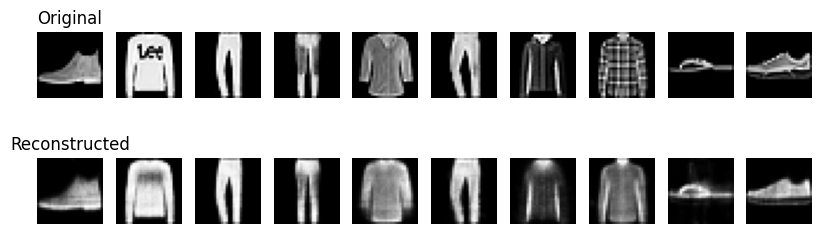

Average SSIM: 0.9997


In [16]:
def compute_ssim(img1,img2, sigma=1.5):
  C1 = (0.01 * 255)**2
  C2 = (0.03 * 255)**2

  img1=img1.astype(np.float64)
  img2=img2.astype(np.float64)

  mu1 = gaussian_filter(img1,sigma)
  mu2 = gaussian_filter(img2,sigma)

  mu1_sq = mu1**2
  mu2_sq = mu2**2
  mu1_mu2 = mu1*mu2

  sigma1_sq = gaussian_filter(img1**2,sigma)-mu1_sq
  sigma2_sq = gaussian_filter(img2**2,sigma)-mu2_sq
  sigma12 = gaussian_filter(img1*img2,sigma)-mu1_mu2

  ssim_map = ((2*mu1_mu2+C1)*(2*sigma12+C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
  return ssim_map.mean()

def evaluate(model,test_loader,n_images=10):
  model.eval()

  with torch.no_grad():
    for batch in test_loader:
      inputs,_=batch
      outputs=model(inputs)
      break

  inputs = inputs.numpy()
  outputs = outputs.numpy()
  fig,axes=plt.subplots(2,n_images,figsize=(n_images,3))

  ssim_scores = [] #structural similarity index measure / measure similarities between two images 1 = same image, 0 = no similarities

  for i in range(n_images):
    img1 = np.squeeze(inputs[i])
    img2 = np.squeeze(outputs[i])

    ssim_score = compute_ssim(img1,img2)
    ssim_scores.append(ssim_score)

    axes[0,i].imshow(img1,cmap='gray')
    axes[0,i].axis("off")
    axes[1,i].imshow(img2,cmap='gray')
    axes[1,i].axis("off")

  axes[0,0].set_title("Original")
  axes[1,0].set_title("Reconstructed")
  plt.show()

  avg_ssim = np.mean(ssim_scores)
  print(f"Average SSIM: {avg_ssim:.4f}")

evaluate(model,test_loader)